In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import nltk
from nltk.corpus import stopwords
import pymorphy2
import re
from tqdm import tqdm

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
from gensim.models import *
from gensim import corpora

###  Пусть нам изначально известно количество тем. И это хороший случай проверить нашу модель. Посмотрим на график и оценим результат на выбранных произвольно кол-ве топиков.

In [5]:
df_full = pd.read_csv('lenta-ru-news.csv')
df_short = df_full[:100000]  # ограничение для более быстрого расчёта
df = df_short[['text', 'topic']]
df.head()

,text,topic
0,Вице-премьер по социальным вопросам Татьяна Го...,Россия
1,Австрийские правоохранительные органы не предс...,Спорт
2,Сотрудники социальной сети Instagram проанализ...,Путешествия
3,С начала расследования российского вмешательст...,Мир
4,Хакерская группировка Anonymous опубликовала н...,Мир


In [6]:
values = df['topic'].unique()
values

array(['Россия', 'Спорт', 'Путешествия', 'Мир', 'Бывший СССР',
       'Интернет и СМИ', 'Силовые структуры', 'Экономика', 'Культура',
       'Дом', 'Наука и техника', 'Из жизни', 'Ценности', 'Бизнес',
       '69-я параллель', nan, 'Культпросвет ', 'Крым', 'Оружие'],
      dtype=object)

In [7]:
vol = ['Россия', 'Спорт', 'Путешествия', 'Мир', 'Бывший СССР',
       'Интернет и СМИ', 'Силовые структуры', 'Экономика', 'Культура',
       'Дом', 'Наука и техника', 'Из жизни', 'Ценности', 'Бизнес',
       '69-я параллель']
len(vol)

15

### Предобработка

In [8]:
morph = pymorphy2.MorphAnalyzer()
words_regex = re.compile('\w+')
stopwords_list = stopwords.words('russian')

def find_words(text, regex = words_regex):
    tokens =  regex.findall(text.lower())
    return [w for w in tokens if w.isalpha() and len(w) >= 3]

def lemmatize(words, lemmer = morph, stopwords = stopwords_list):
    lemmas = [lemmer.parse(w)[0].normal_form for w in words]
    return [w for w in lemmas if not w in stopwords
            and w.isalpha()]

def preprocess(text):
    return (lemmatize(find_words(text)))

In [9]:
prep_text = df['text'].apply(preprocess)

In [10]:
df['text'] = prep_text
df.head()

,text,topic
0,"[вица, премьер, социальный, вопрос, татьяна, г...",Россия
1,"[австрийский, правоохранительный, орган, предс...",Спорт
2,"[сотрудник, социальный, сеть, instagram, проан...",Путешествия
3,"[начало, расследование, российский, вмешательс...",Мир
4,"[хакерский, группировка, anonymous, опубликова...",Мир


### Модель

In [11]:
dictionary = corpora.Dictionary(df['text'])

dictionary.filter_extremes(no_below = 10, no_above = 0.9, keep_n=None)
dictionary.save('news.dict')

In [12]:
corpus = [dictionary.doc2bow(text) for text in df['text']]
corpora.MmCorpus.serialize('news.model', corpus)

In [13]:
lda = ldamodel.LdaModel(corpus, id2word=dictionary, num_topics=10,
                        chunksize=50, update_every=1, passes=2)

### Оценки качества

In [14]:
print('Персплексия: ', np.exp(lda.log_perplexity(corpus)))

Персплексия:  0.0001441220461497907


In [15]:
coherence_model_lda = CoherenceModel(model=lda, texts=df['text'], dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('Средняя когерентность: ', coherence_lda)

Средняя когерентность:  0.4765615128563884


### График

100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [43:46<00:00, 375.20s/it]


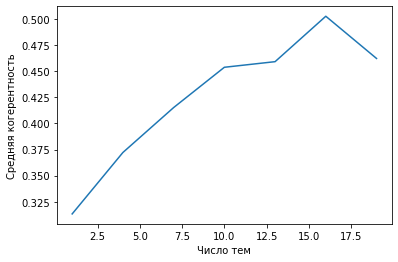

In [16]:
topics_list = [i for i in range(1, 20, 3)]
coherences = []

for num in tqdm(topics_list):
    lda = ldamodel.LdaModel(corpus, id2word=dictionary, num_topics=num, chunksize=50, update_every=1, passes=2)
    coherences.append(CoherenceModel(model=lda, texts=df['text'], dictionary=dictionary, coherence='c_v').get_coherence())

plt.plot(topics_list, coherences)
plt.xlabel("Число тем")
plt.ylabel("Средняя когерентность")
plt.show()

### Замечания

##### В действительности некоторые темы очень близки, как-то: Россия - Бывший СССР, Экономика - Бизнес, Мир - Путешествия, Культура - Ценности. Поэтому справедливо говорить о 10-15 топ. Эту особенность можно увидеть на графике.